In [1]:
import vof
from vof import forecaster
from vof import optimizer

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
import statsmodels.tsa.stattools
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import time
import random
#from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from datetime import date
import nevergrad as ng

plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams.update({'font.size': 22})

data = pd.read_csv("data/district/predictions_2019.csv", index_col=0, parse_dates=True)#pd.read_csv('sales_FOODS_3_090_TX_2.csv')
data.head(5)

,Prophet 30d,CB Model 30d,Prophet 60d,LR Model 240d,LR Model 30d,LR Model 60d,LR Model 120d,Prophet 120d,Theta 30d,Theta 60d,Theta 120d,Theta 240d,CB Model 60d,CB Model 240d,CB Model 120d,Prophet 240d,Fact,SNaive
Time,,,,,,,,,,,,,,,,,,
2019-01-02 00:00:00,9.712369,9.516061,9.732844,10.082039,10.034193,9.860739,9.931228,9.475604,9.992034,9.986460,10.074619,10.037784,9.478454,9.477245,9.469355,9.521947,9.791285,9.587180
2019-01-02 01:00:00,9.537794,9.329764,9.526740,9.905469,9.848606,9.685257,9.755594,9.250441,9.799050,9.784246,9.843274,9.809841,9.314212,9.310756,9.320833,9.283847,9.595427,9.421677
2019-01-02 02:00:00,9.346844,9.225298,9.357172,9.752310,9.685450,9.537204,9.604944,9.048528,9.646126,9.618324,9.656499,9.620984,9.217455,9.230141,9.192942,9.021519,9.538146,9.302606
2019-01-02 03:00:00,9.238202,9.140338,9.258282,9.633302,9.547768,9.422706,9.488390,8.965614,9.534998,9.506044,9.530117,9.501419,9.155913,9.161070,9.141137,8.909141,9.420105,9.151197
2019-01-02 04:00:00,9.222486,9.122567,9.222533,9.600721,9.502948,9.403288,9.459666,8.902531,9.499663,9.469673,9.476750,9.455269,9.125739,9.136762,9.136573,8.850692,9.364424,9.159970


EVALUATE = False
TIME_HORIZON = 168
DECISION_TIMESTEP = 24
PEAK_POWER_LIMIT = 12
BATTERY_CHARGE = 0
BATTERY_CAPACITY = 1000
BATTERY_EFFICIENCY = .99

solution = ng.p.Array(shape=(12,)).set_bounds(lower=-80, upper=80)
battery_charge =BATTERY_CHARGE

x = data#.drop([target], axis=1)
y = data['Fact']

step=1
candidate = x.iloc[step:step+TIME_HORIZON,0]

instru = ng.p.Instrumentation(solution,battery_charge)

    def cost_function(self,solution,battery_charge):
        
        print(battery_charge)
        cumsum = np.cumsum(solution) + battery_charge#self.BATTERY_CHARGE

        #battery capacity penalty:
        violations_battery = (np.sum(np.where(cumsum>BATTERY_CAPACITY)) + np.sum(np.where(cumsum<0))) * 10000
        
        
        #penalty for putting electricity back to the grid
        if EVALUATE:
            grid_load = (self.y+solution).values
        else:
            grid_load = (self.candidate+solution).values
        violations_demand = -np.sum(grid_load[np.where(grid_load<0)]) * 10000

        #penlty for high peak in load
        margin = (self.PEAK_POWER_LIMIT - grid_load)
        violations_peak = -np.sum(margin[np.where(margin < 0)]) * 10000

        #penalty for battery losses
        battery_usage = (1 - BATTERY_EFFICIENCY) * np.sum(np.abs(solution)) * 1000

        total_cost = violations_battery + violations_demand + violations_peak + battery_usage
        #print(violations_battery,violations_demand,violations_peak,battery_usage)
        return total_cost


optimizer = ng.optimizers.NGOpt(parametrization=instru, budget=100)
recommendation = optimizer.minimize(myfunction)
print(recommendation.value)

## Recursive forecaster

In [2]:
tmp = forecaster.RecursiveForecaster(data[['Fact']], 
                          target='Fact')
tmp.x

""
Time
2019-01-02 00:00:00
2019-01-02 01:00:00
2019-01-02 02:00:00
2019-01-02 03:00:00
2019-01-02 04:00:00
...
2019-12-31 19:00:00
2019-12-31 20:00:00
2019-12-31 21:00:00


In [3]:
def estimateSignificantLags(ts, nlags = 360, significantLags = 11): 
    pacf = sm.tsa.stattools.pacf(ts, nlags)
    lags = np.argsort(-np.abs(pacf))[1:significantLags+1]
    plt.plot(pacf,'*--')
    plt.plot(lags,pacf[lags],'o')
    return lags

[  1   2   3   5  23  24  26  50 168 169]


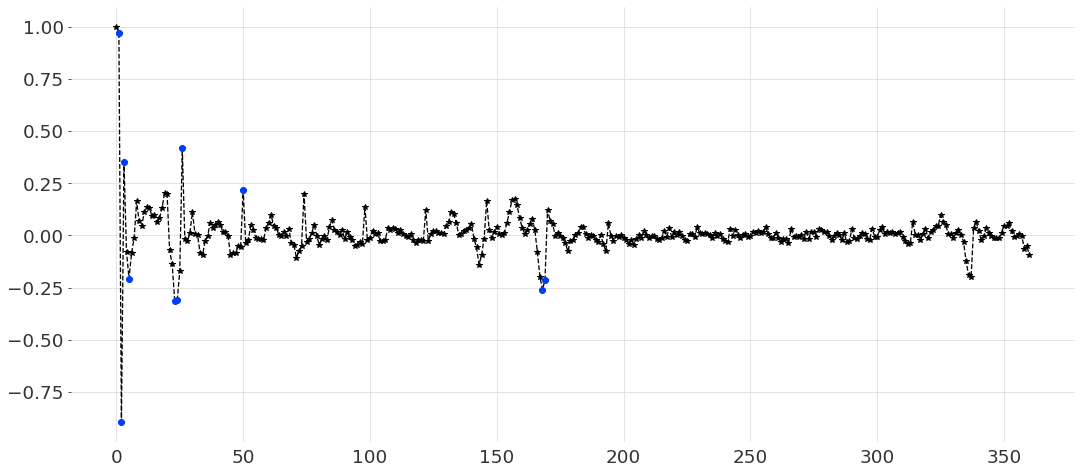

In [4]:
lags = estimateSignificantLags(tmp.y, significantLags = 10)
# add lags for certain days
lags = np.unique(np.hstack([lags]))
print(np.sort(lags))

In [5]:
tmp.add_lag_features(np.sort(lags))

In [6]:
tmp.x.loc['2019-01-02 01:00:00'].values[0]

9.791284841

In [20]:
sday='2019-01-12'
lknown_day='2019-03-01'
pred_day='2019-03-02'
terminal_day = '2019-04-01'

pred_days = pd.date_range(start=pred_day,
                          end=terminal_day, freq='D')

start_days = pd.date_range(start=sday,
                           periods=len(pred_days), freq='D')

last_known_days = pd.date_range(start=lknown_day,
                           periods=len(pred_days), freq='D')

forecast_for_days = pd.DataFrame(index=tmp.x.loc[pred_day:].index)

for (pd_day,st_day,lk_day) in zip(pred_days,start_days,last_known_days):
    
    print(pd_day,st_day,lk_day)
    
    res = tmp.create_single_prediction(RandomForestRegressor(),
                      start_day=st_day,
                      last_known_day=lk_day,
                      prediction_day=pd_day,
                      frequency='H',
                      horizon=72)
    
    forecast_for_days[pd_day] = res

forecast_for_days.head(10)

2019-03-02 00:00:00 2019-01-12 00:00:00 2019-03-01 00:00:00
RandomForestRegressor()


INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


2019-03-03 00:00:00 2019-01-13 00:00:00 2019-03-02 00:00:00
RandomForestRegressor()
2019-03-04 00:00:00 2019-01-14 00:00:00 2019-03-03 00:00:00
RandomForestRegressor()
2019-03-05 00:00:00 2019-01-15 00:00:00 2019-03-04 00:00:00
RandomForestRegressor()
2019-03-06 00:00:00 2019-01-16 00:00:00 2019-03-05 00:00:00
RandomForestRegressor()
2019-03-07 00:00:00 2019-01-17 00:00:00 2019-03-06 00:00:00
RandomForestRegressor()
2019-03-08 00:00:00 2019-01-18 00:00:00 2019-03-07 00:00:00
RandomForestRegressor()
2019-03-09 00:00:00 2019-01-19 00:00:00 2019-03-08 00:00:00
RandomForestRegressor()
2019-03-10 00:00:00 2019-01-20 00:00:00 2019-03-09 00:00:00
RandomForestRegressor()
2019-03-11 00:00:00 2019-01-21 00:00:00 2019-03-10 00:00:00
RandomForestRegressor()
2019-03-12 00:00:00 2019-01-22 00:00:00 2019-03-11 00:00:00
RandomForestRegressor()
2019-03-13 00:00:00 2019-01-23 00:00:00 2019-03-12 00:00:00
RandomForestRegressor()
2019-03-14 00:00:00 2019-01-24 00:00:00 2019-03-13 00:00:00
RandomForestRegr

,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,...,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31,2019-04-01
Time,,,,,,,,,,,,,,,,,,,,,
2019-03-02 00:00:00,10.878787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02 01:00:00,10.6252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02 02:00:00,10.408565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02 03:00:00,10.270041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02 04:00:00,10.267274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02 05:00:00,10.348066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02 06:00:00,10.557964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02 07:00:00,10.906466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02 08:00:00,11.484741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


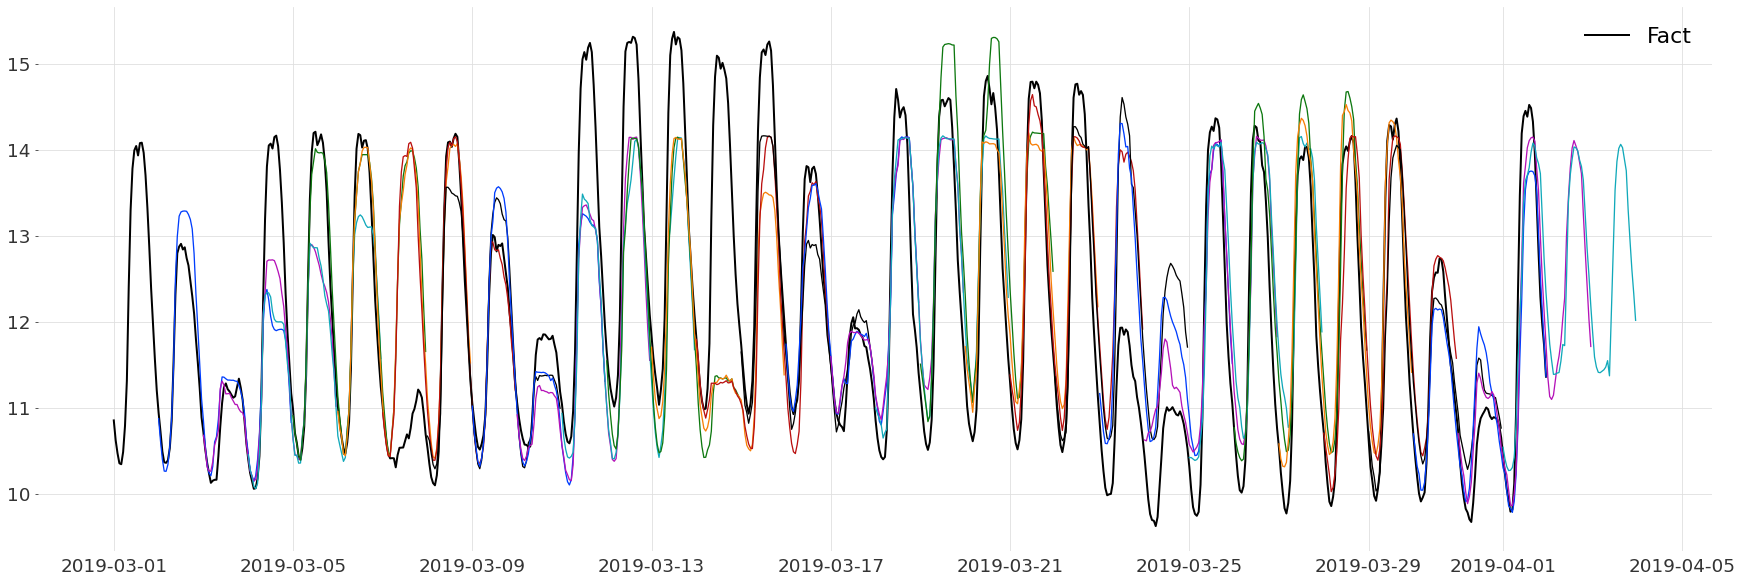

In [21]:
plt.figure(figsize=(30,10))
plt.plot(tmp.y.loc['2019-03-01':'2019-04-01'], label='Fact', lw=2)

for col in forecast_for_days.columns:
    plt.plot(forecast_for_days[col])


plt.legend()

In [9]:
sday='2019-01-12'
lknown_day='2019-03-01'
pred_day='2019-03-02'
terminal_day = '2019-04-01'

recursive_forecast = tmp.create_recursive_prediction(RandomForestRegressor(),
                      start_day=sday,
                      last_known_day=lknown_day,
                      prediction_day=pred_day,
                      terminal_day=terminal_day,
                      freq='H',
                      h=72)

2019-03-02 00:00:00 2019-01-12 00:00:00 2019-03-01 00:00:00
RandomForestRegressor()


INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


2019-03-03 00:00:00 2019-01-13 00:00:00 2019-03-02 00:00:00
RandomForestRegressor()
2019-03-04 00:00:00 2019-01-14 00:00:00 2019-03-03 00:00:00
RandomForestRegressor()
2019-03-05 00:00:00 2019-01-15 00:00:00 2019-03-04 00:00:00
RandomForestRegressor()
2019-03-06 00:00:00 2019-01-16 00:00:00 2019-03-05 00:00:00
RandomForestRegressor()
2019-03-07 00:00:00 2019-01-17 00:00:00 2019-03-06 00:00:00
RandomForestRegressor()
2019-03-08 00:00:00 2019-01-18 00:00:00 2019-03-07 00:00:00
RandomForestRegressor()
2019-03-09 00:00:00 2019-01-19 00:00:00 2019-03-08 00:00:00
RandomForestRegressor()
2019-03-10 00:00:00 2019-01-20 00:00:00 2019-03-09 00:00:00
RandomForestRegressor()
2019-03-11 00:00:00 2019-01-21 00:00:00 2019-03-10 00:00:00
RandomForestRegressor()
2019-03-12 00:00:00 2019-01-22 00:00:00 2019-03-11 00:00:00
RandomForestRegressor()
2019-03-13 00:00:00 2019-01-23 00:00:00 2019-03-12 00:00:00
RandomForestRegressor()
2019-03-14 00:00:00 2019-01-24 00:00:00 2019-03-13 00:00:00
RandomForestRegr

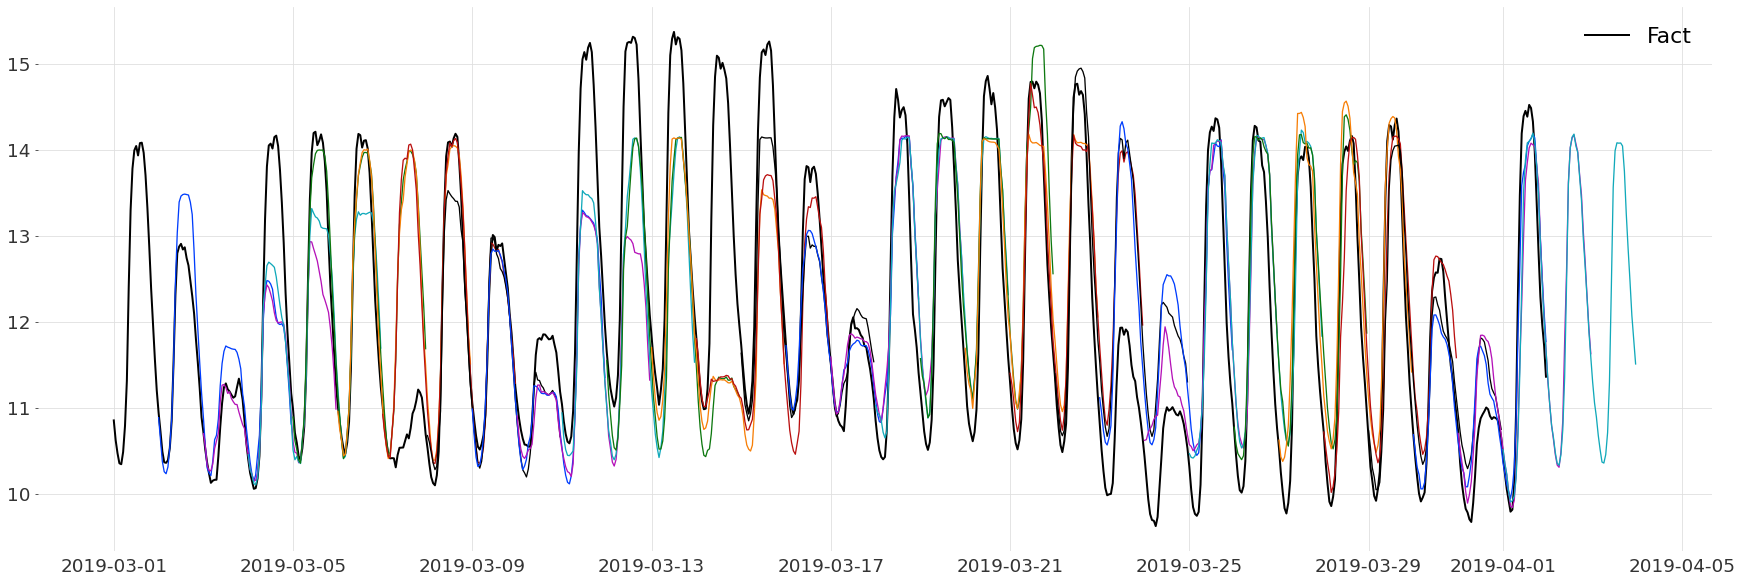

In [10]:
plt.figure(figsize=(30,10))
plt.plot(tmp.y.loc['2019-03-01':'2019-04-01'], label='Fact', lw=2)

for col in recursive_forecast.columns:
    plt.plot(recursive_forecast[col])


plt.legend()